# IY011 Simulate telegraph model using Julia implementation, with Sobol sequence for parameter sampling

We simulated some data via Sobol sequence sampling in ``IY011_simulation.py``, but now we want to inspect the data visually. This notebook does that.


```python
# to simulate data, we can use the following code. this is the basis of IY011_simulation.py.
from simulation.julia_simulate_telegraph_model import simulate_telegraph_model
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

parameter_sets = [{
    'sigma_b': 1.0,
    'sigma_u': 0.1,
    'rho': 10,
    'd': 1.0,
    'label': 0
}]
time_points = np.arange(0, 100, 1.0)
size = 1000
df = simulate_telegraph_model(parameter_sets, time_points, size)

---
## Visualisation

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualisation.plots import plot_mRNA_dist, plot_mRNA_trajectory
from simulation.julia_simulate_telegraph_model import simulate_telegraph_model
%load_ext autoreload
%autoreload 2  

In [2]:
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data")
RESULTS_PATH = DATA_ROOT / "IY011_simulation_parameters_sobol.csv"
SHARD_TEMPLATE = "IY011_synth_shard_{:03d}"
SHARD_SIZE = 16
TRAJECTORIES_PER_COMBO = 500

df_params = pd.read_csv(RESULTS_PATH)
TRAJ_PATH = [DATA_ROOT / f"mRNA_trajectories_mu{row['mu_target']:.3f}_cv{row['cv_target']:.3f}_tac{row['t_ac_target']:.3f}.csv" for idx, row in df_params.iterrows()]

In [3]:
# extract meta data
parameter_sets = [{
    'sigma_b': row['sigma_b'],
    'sigma_u': row['sigma_u'],
    'rho': row['rho'],
    'd': row['d'],
    'label': 0
} for idx, row in df_params.iterrows()]
time_points = np.arange(0, 3000, 1.0)

plot the first parameter set's trajectory, the distribution and the autocorrelation.

In [4]:
# get the meta-data for the first parameter set
parameter_sets_0 = [parameter_sets[0]]
# just the first one
mu_target, cv_target, t_ac_target = df_params.iloc[0]['mu_target'], df_params.iloc[0]['cv_target'], df_params.iloc[0]['t_ac_target'] 
df = pd.read_csv(TRAJ_PATH[0])
df_traj = df.drop(columns=['label'], errors='ignore') # drop in-place if it exists, do nothing otherwise

In [10]:
# Now calculate the stats from the simulated data
from stats.mean import calculate_mean
from stats.variance import calculate_variance
from stats.cv import calculate_cv
from stats.autocorrelation import calculate_autocorrelation, calculate_ac_time_interp1d
mean_observed = calculate_mean(df_traj, parameter_sets, use_steady_state=False) # note the df is transposed
variance_observed = calculate_variance(df_traj, parameter_sets, use_steady_state=False)
cv_observed = calculate_cv(variance_observed, mean_observed)

# Calculate autocorrelation
autocorr_results = calculate_autocorrelation(df_traj)
ac_mean = autocorr_results['stress_ac'].mean(axis=0)
lags = autocorr_results['stress_lags']
t_ac_observed = calculate_ac_time_interp1d(ac_mean, lags)

# Calculate errors
mean_error_pct = 100 * abs(np.mean(mean_observed) - mu_target) / mu_target
cv_error_pct = 100 * abs(np.mean(cv_observed) - cv_target) / cv_target
t_ac_error_pct = 100 * abs(t_ac_observed - t_ac_target) / t_ac_target

###############################################################
# Reporting 
###############################################################
# Print results
print(f"Mean: Target = {mu_target}, Observed = {np.mean(mean_observed):.3f} (Error: {mean_error_pct:.1f}%)")
print(f"CV: Target = {cv_target}, Observed = {np.mean(cv_observed):.3f} (Error: {cv_error_pct:.1f}%)")
print(f"Variance: Observed = {np.mean(variance_observed):.3f}")
print(f"AC Time: Target = {t_ac_target}, Observed = {t_ac_observed:.3f} (Error: {t_ac_error_pct:.1f}%)")


Mean: Target = 4310.863714152947, Observed = 4456.939 (Error: 3.4%)
CV: Target = 1.7215519584715366, Observed = 1.698 (Error: 1.4%)
Variance: Observed = 56460268.219
AC Time: Target = 97.73746816907078, Observed = 102.653 (Error: 5.0%)


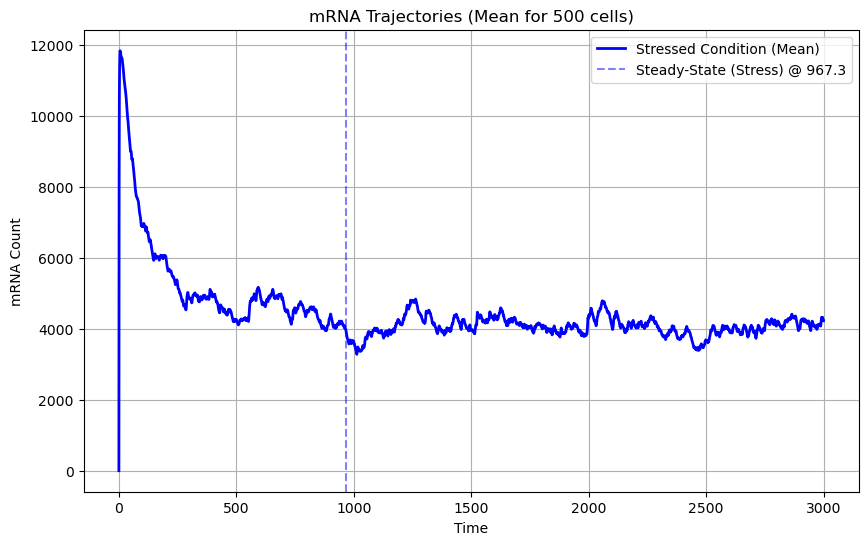

In [6]:
# Create and save traj plot
fig, ax = plot_mRNA_trajectory(parameter_sets_0, time_points, df_traj)  
plt.close(fig)

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


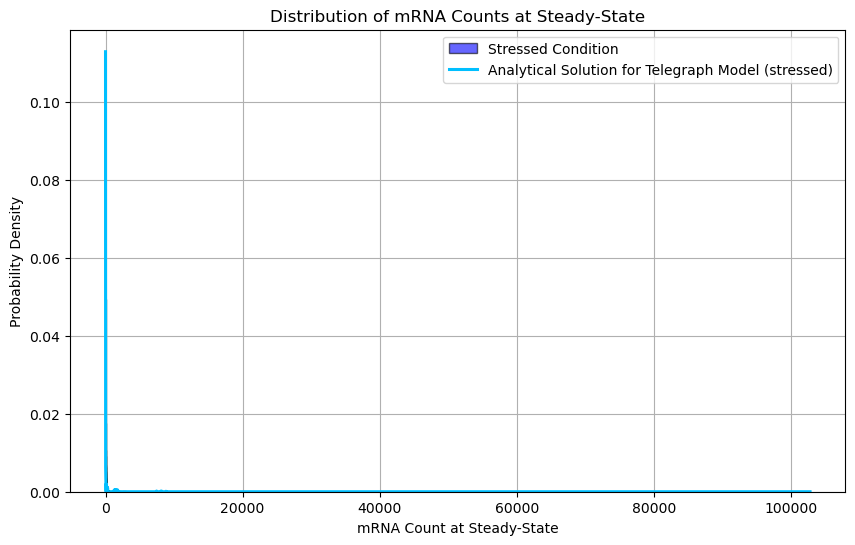

In [7]:
# Plot data distribution
fig, ax = plot_mRNA_dist(parameter_sets_0, df_traj, kde=False)
plt.close(fig)

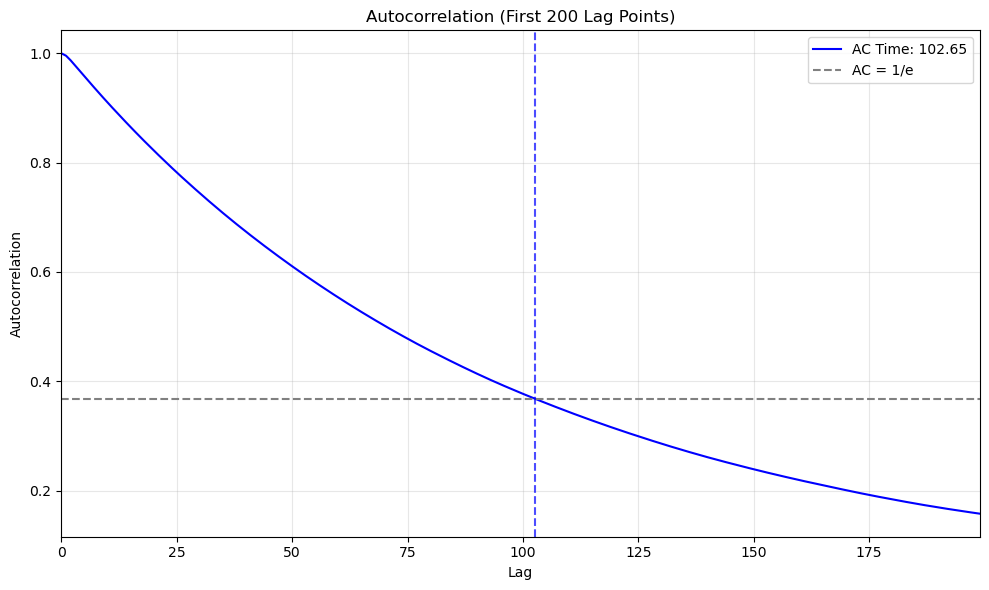

In [8]:
# Plot autocorrelation
plt.figure(figsize=(10, 6))
# Find indices for positive lags only (autocorrelation is symmetric)
positive_mask = lags >= 0
positive_lags = lags[positive_mask]
positive_mean_ac = ac_mean[positive_mask]
# Limit to first 200 points
max_lag_points = min(200, len(positive_lags))
plot_lags = positive_lags[:max_lag_points]
plot_ac = positive_mean_ac[:max_lag_points]
# Plot stress condition (zoomed in)
plt.plot(plot_lags, plot_ac, color='blue', label=f'AC Time: {t_ac_observed:.2f}')
# Plot the AC time lines, show the values (only if within the plot range)
plt.axhline(y=1/np.e, color='gray', linestyle='--', label='AC = 1/e')
if t_ac_observed <= plot_lags[-1]:  # Only show vertical line if it's within the plot range
    plt.axvline(x=t_ac_observed, color='blue', linestyle='--', alpha=0.7)
plt.title('Autocorrelation (First 200 Lag Points)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xlim(0, plot_lags[-1])  # Set x-axis limits explicitly
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plot a few more trajectories and distributions

Mean: Target = 4310.863714152947, Observed = 4456.939 (Error: 3.4%)
CV: Target = 1.7215519584715366, Observed = 1.698 (Error: 1.4%)
Variance: Observed = 56460268.219
AC Time: Target = 97.73746816907078, Observed = 102.653 (Error: 5.0%)


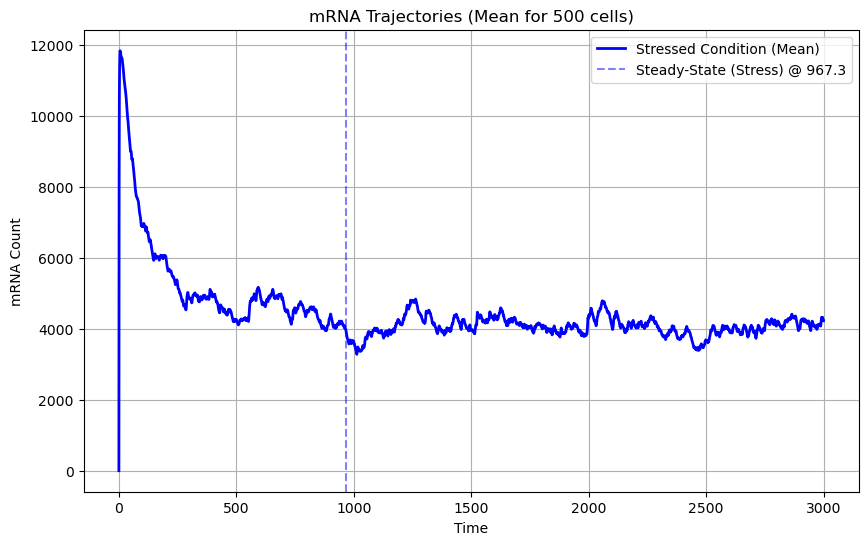

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


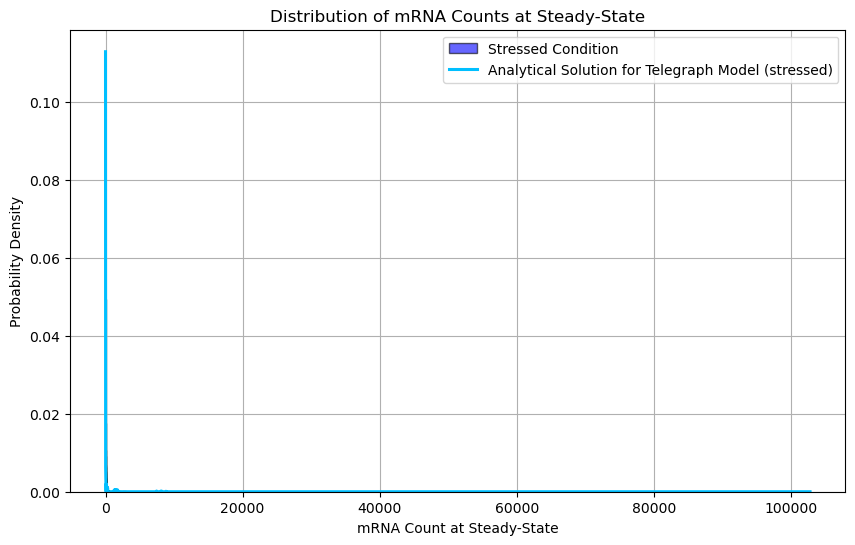

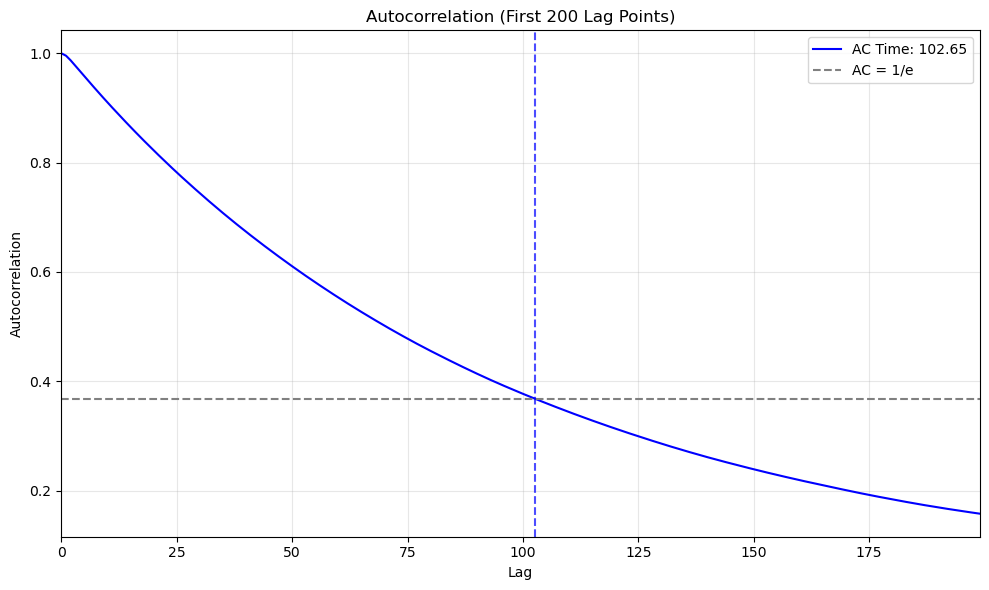

Mean: Target = 8698.265540089458, Observed = 8516.339 (Error: 2.1%)
CV: Target = 1.1562416306696832, Observed = 1.160 (Error: 0.3%)
Variance: Observed = 98095131.645
AC Time: Target = 62.35448905732483, Observed = 61.688 (Error: 1.1%)


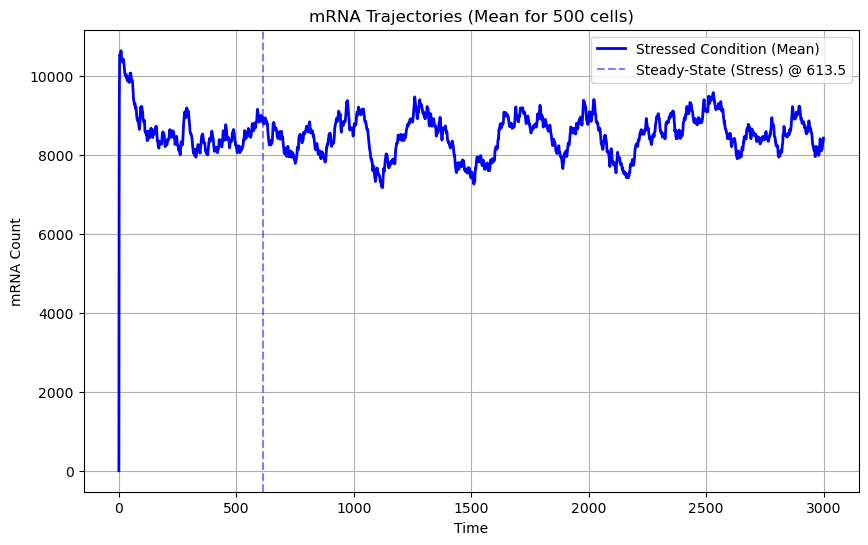

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


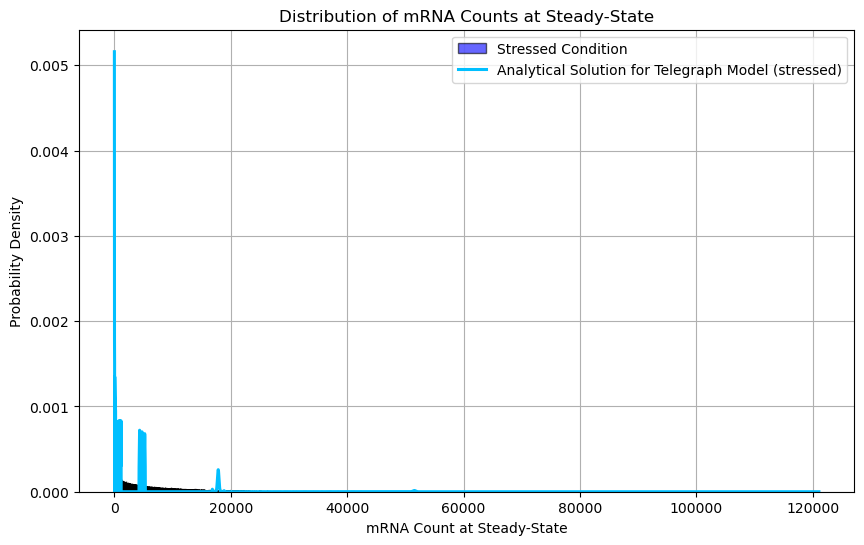

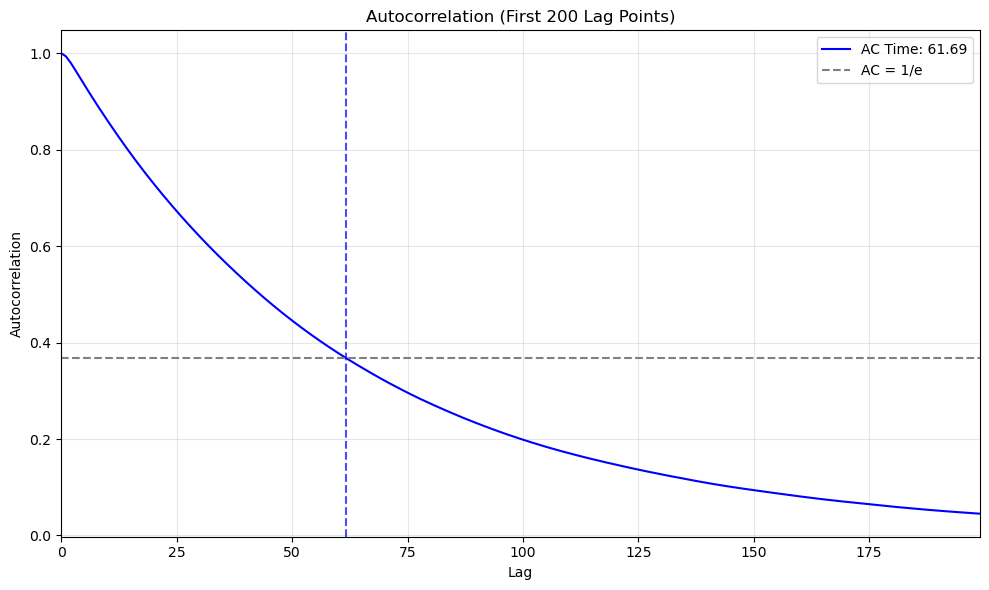

Mean: Target = 5779.576590130106, Observed = 5878.835 (Error: 1.7%)
CV: Target = 1.2652416666969657, Observed = 1.256 (Error: 0.7%)
Variance: Observed = 54506582.631
AC Time: Target = 88.54406008031219, Observed = 86.920 (Error: 1.8%)


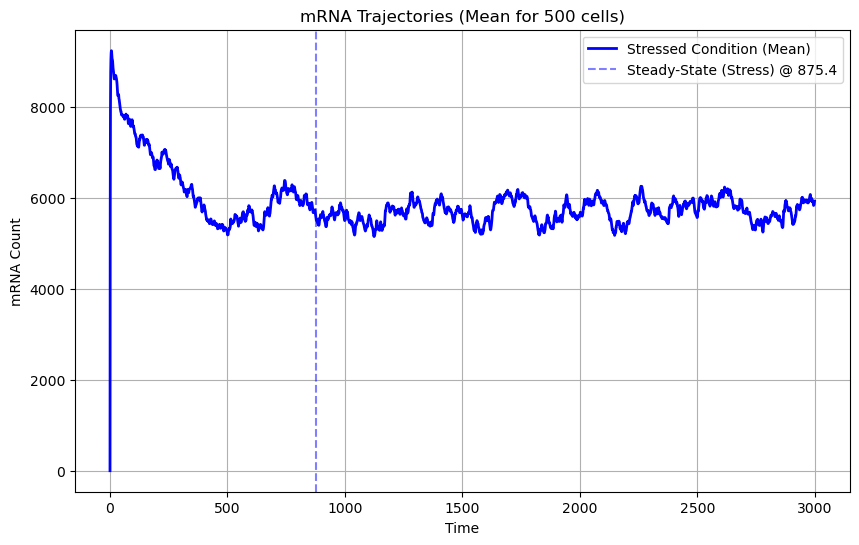

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


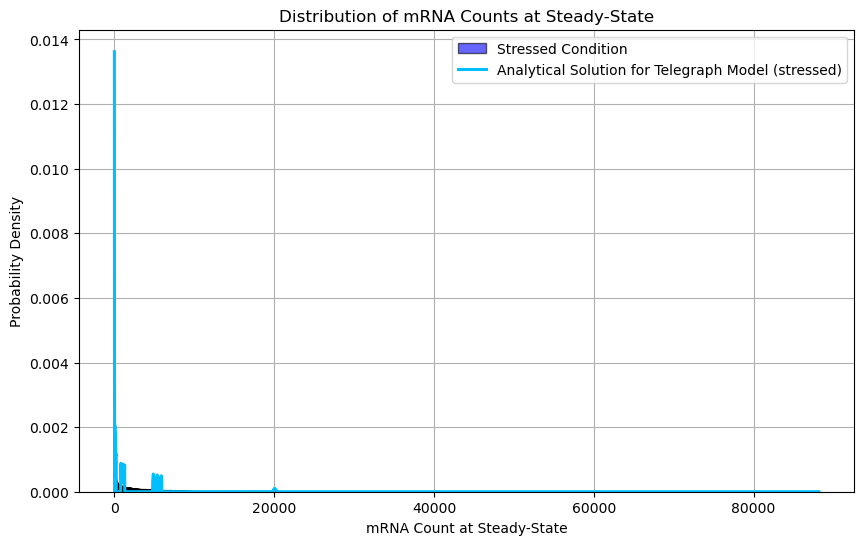

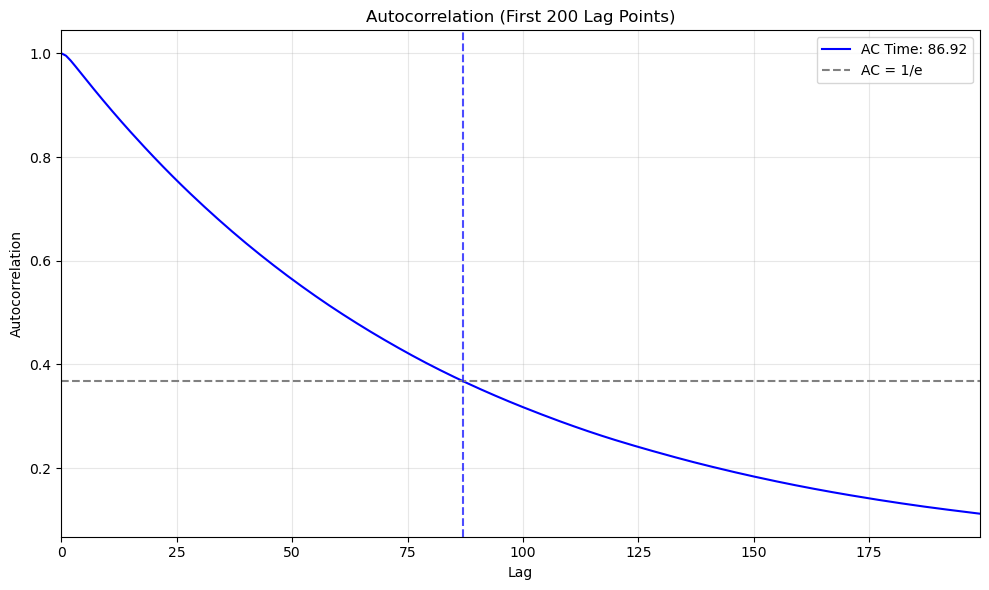

Mean: Target = 1369.528418879956, Observed = 1368.746 (Error: 0.1%)
CV: Target = 0.858065799344331, Observed = 0.857 (Error: 0.1%)
Variance: Observed = 1377903.227
AC Time: Target = 8.660342977382243, Observed = 8.616 (Error: 0.5%)


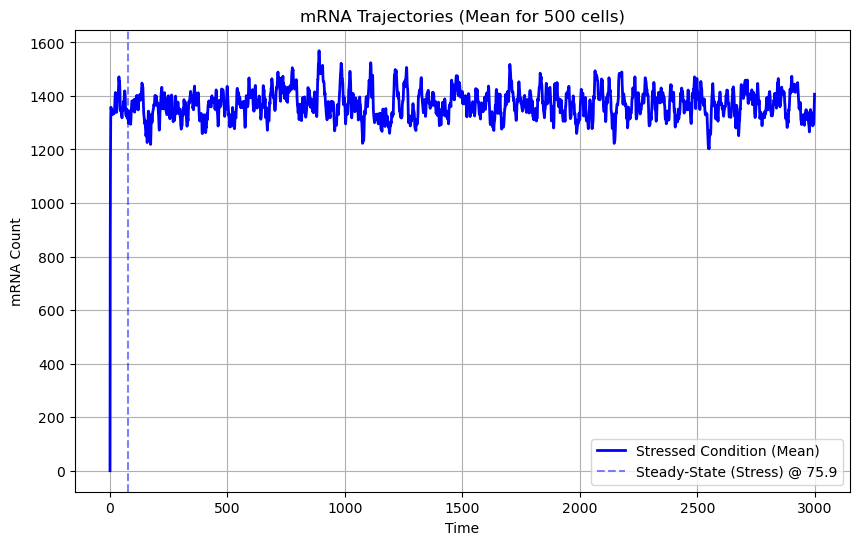

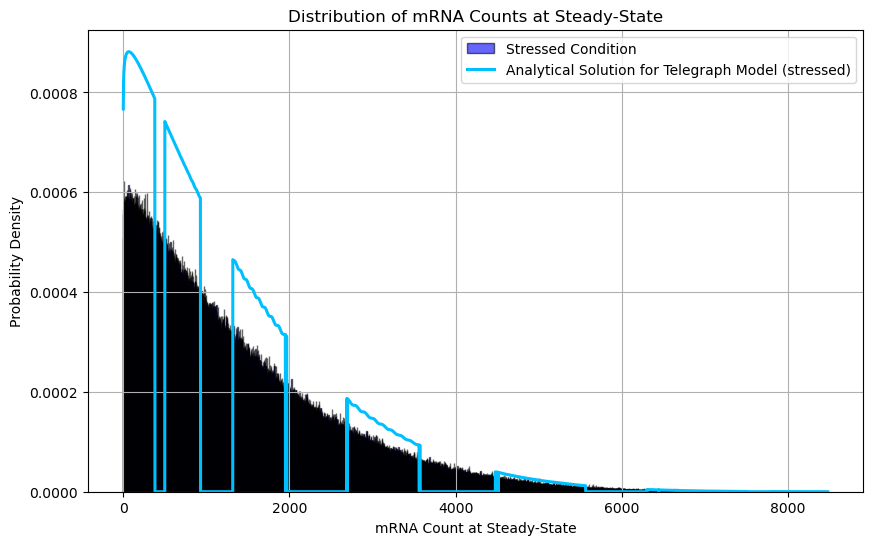

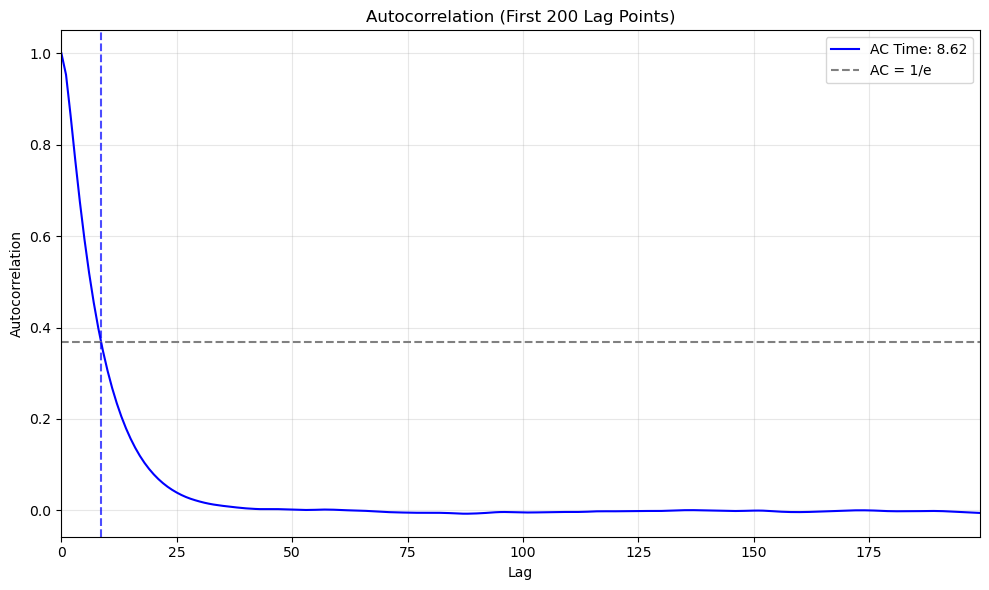

Mean: Target = 434.89962587784976, Observed = 445.556 (Error: 2.5%)
CV: Target = 1.572467294987291, Observed = 1.532 (Error: 2.6%)
Variance: Observed = 464158.565
AC Time: Target = 45.96025404054672, Observed = 44.685 (Error: 2.8%)


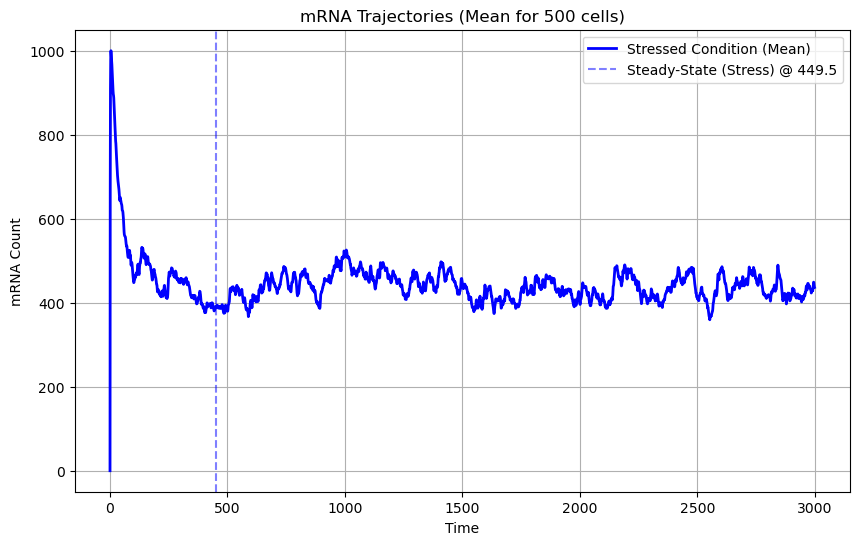

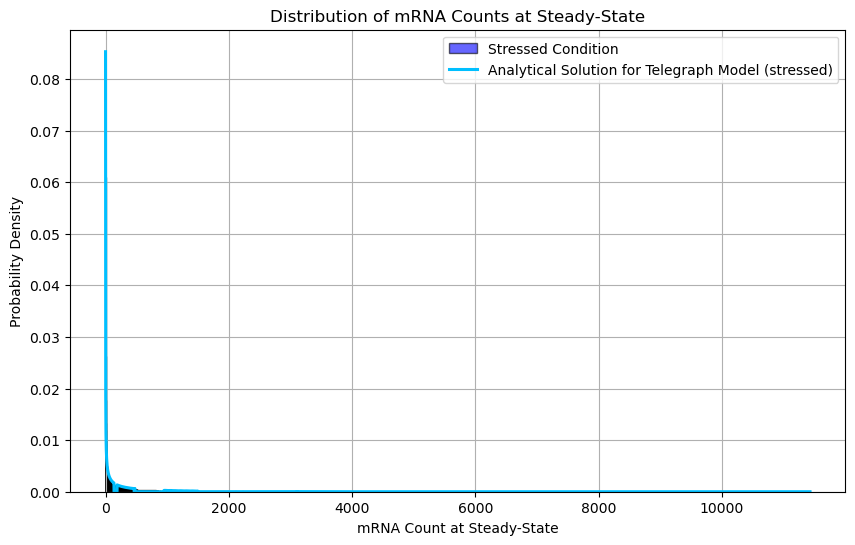

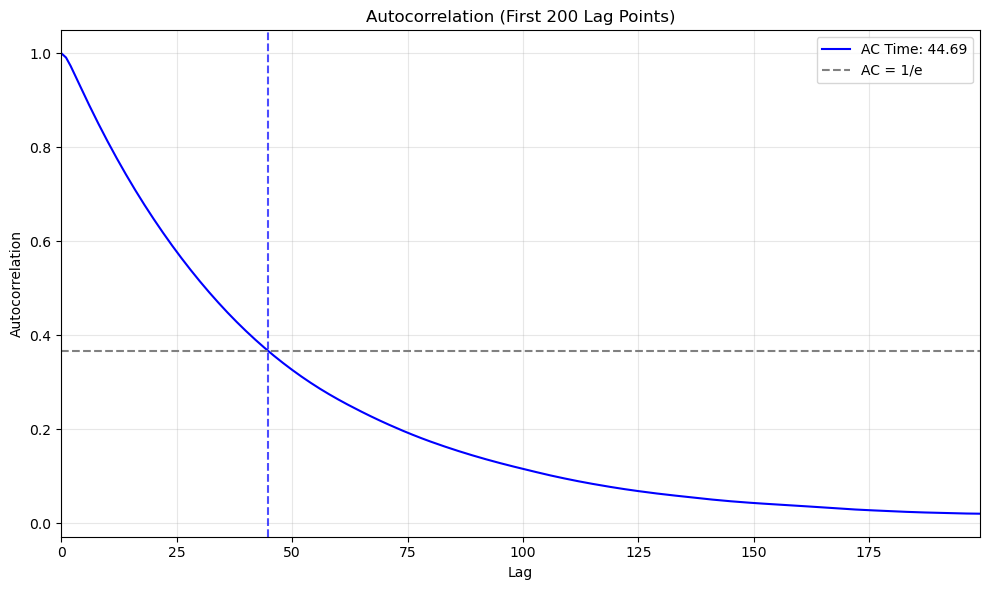

In [11]:
# plot a few more trajectories and distributions
for i, param_set in enumerate(parameter_sets[:5]):
    mu_target, cv_target, t_ac_target = df_params.iloc[i]['mu_target'], df_params.iloc[i]['cv_target'], df_params.iloc[i]['t_ac_target'] 
    df = pd.read_csv(TRAJ_PATH[i])
    df_traj = df.drop(columns=['label'], errors='ignore') # drop in-place if it exists, do nothing otherwise

    # stats
    mean_observed = calculate_mean(df_traj, parameter_sets, use_steady_state=False) # note the df is transposed
    variance_observed = calculate_variance(df_traj, parameter_sets, use_steady_state=False)
    cv_observed = calculate_cv(variance_observed, mean_observed)

    # Calculate autocorrelation
    autocorr_results = calculate_autocorrelation(df_traj)
    ac_mean = autocorr_results['stress_ac'].mean(axis=0)
    lags = autocorr_results['stress_lags']
    t_ac_observed = calculate_ac_time_interp1d(ac_mean, lags)

    # Calculate errors
    mean_error_pct = 100 * abs(np.mean(mean_observed) - mu_target) / mu_target
    cv_error_pct = 100 * abs(np.mean(cv_observed) - cv_target) / cv_target
    t_ac_error_pct = 100 * abs(t_ac_observed - t_ac_target) / t_ac_target
    
    # Print results
    print(f"Mean: Target = {mu_target}, Observed = {np.mean(mean_observed):.3f} (Error: {mean_error_pct:.1f}%)")
    print(f"CV: Target = {cv_target}, Observed = {np.mean(cv_observed):.3f} (Error: {cv_error_pct:.1f}%)")
    print(f"Variance: Observed = {np.mean(variance_observed):.3f}")
    print(f"AC Time: Target = {t_ac_target}, Observed = {t_ac_observed:.3f} (Error: {t_ac_error_pct:.1f}%)")
    
    # plots
    fig, ax = plot_mRNA_trajectory([param_set], time_points, df_traj)  
    plt.close(fig)
    fig, ax = plot_mRNA_dist([param_set], df_traj, kde=False)
    plt.close(fig)
    
    # Plot autocorrelation
    plt.figure(figsize=(10, 6))
    # Find indices for positive lags only (autocorrelation is symmetric)
    positive_mask = lags >= 0
    positive_lags = lags[positive_mask]
    positive_mean_ac = ac_mean[positive_mask]
    # Limit to first 200 points
    max_lag_points = min(200, len(positive_lags))
    plot_lags = positive_lags[:max_lag_points]
    plot_ac = positive_mean_ac[:max_lag_points]
    # Plot stress condition (zoomed in)
    plt.plot(plot_lags, plot_ac, color='blue', label=f'AC Time: {t_ac_observed:.2f}')
    # Plot the AC time lines, show the values (only if within the plot range)
    plt.axhline(y=1/np.e, color='gray', linestyle='--', label='AC = 1/e')
    if t_ac_observed <= plot_lags[-1]:  # Only show vertical line if it's within the plot range
        plt.axvline(x=t_ac_observed, color='blue', linestyle='--', alpha=0.7)
    plt.title('Autocorrelation (First 200 Lag Points)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.xlim(0, plot_lags[-1])  # Set x-axis limits explicitly
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
        